In [3]:
import string
import copy
import time
%matplotlib inline
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, TensorDataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, AdamW
from torch.optim import SGD
import random
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter


SEED = 42
BATCH_SIZE = 16
MAX_LENGTH = 321
ROBERTA_FP = '../input/roberta-base'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONASSEED'] = str(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [2]:
pip install torch-lr-finder

Note: you may need to restart the kernel to use updated packages.


In [4]:
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [5]:
def children(m):
    return m if isinstance(m, (list, tuple)) else list(m.children())


def set_trainable_attr(m, b):
    m.trainable = b
    for p in m.parameters():
        p.requires_grad = b


def apply_leaf(m, f):
    c = children(m)
    if isinstance(m, nn.Module):
        f(m)
    if len(c) > 0:
        for l in c:
            apply_leaf(l, f)


def set_trainable(l, b):
    apply_leaf(l, lambda m: set_trainable_attr(m, b))

In [6]:
class RobertaForSequenceRegression(nn.Module):
    def __init__(self):
        super(RobertaForSequenceRegression, self).__init__()
        self.roberta = RobertaModel.from_pretrained(ROBERTA_FP)
        self.dropout = nn.Dropout(self.roberta.config.hidden_dropout_prob)
        self.linear1 = nn.Linear(self.roberta.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(256, 1)

    def forward(self, ids,  attention_mask):
        _, pooled_output = self.roberta(ids, attention_mask, return_dict=False)
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.linear1(pooled_output)
        pooled_output = self.relu(pooled_output)
        outputs = self.linear2(pooled_output)
        return outputs.view(-1)

In [7]:
def RMSELoss(outputs, targets):
    return torch.sqrt(nn.MSELoss()(outputs, targets))

In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer

class regressor_stratified_cv:
    def __init__(self, n_splits = 10, n_repeats = 2, group_count = 10,
                 random_state = 0, strategy = 'quantile'):
        self.group_count = group_count
        self.strategy = strategy
        self.cvkwargs = dict(n_splits = n_splits, n_repeats = n_repeats, 
                             random_state = random_state)
        self.cv = RepeatedStratifiedKFold(**self.cvkwargs)
        self.discretizer = KBinsDiscretizer(n_bins = self.group_count, encode = 'ordinal',
                                            strategy = self.strategy)  
            
    def split(self, X, y, groups = None):
        kgroups=self.discretizer.fit_transform(y[:, None])[:, 0]
        return self.cv.split(X, kgroups, groups)
    
    def get_n_splits(self, X, y, groups = None):
        return self.cv.get_n_splits(X, y, groups)

In [9]:
def text_preprocessing(excerpt):
    
    # lower casing
    excerpt = excerpt.lower()

    # removal of punctuation
    excerpt = excerpt.translate(str.maketrans('', '', string.punctuation))

                
    return excerpt

In [10]:
class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        inputs = batch_data["ids"], batch_data["mask"]
        labels = batch_data["targets"] 
        return  inputs, labels

In [11]:
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, inputs):
        ids, attention_mask = inputs
        return self.model(ids=ids, attention_mask=attention_mask)

In [12]:
df = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [13]:
df["text"] = df["excerpt"].apply(lambda x: text_preprocessing(x))

In [14]:
excerpts = df.text.values
targets = df.target.values

In [15]:
# Load the ROBERTA tokenizer.
tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_FP)

In [16]:
class TokenDataset(Dataset):
    def __init__(self, tokenizer, text, target = None, is_test=False):
        self.text = text
        self.target = target
        self.is_test = is_test
        self.max_len = MAX_LENGTH
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        text = str(self.text[idx])
        text = ' '.join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length = self.max_len,
            padding='max_length',
#             add_special_tokens=True,
            return_attention_mask=True
        )
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        
        if self.is_test:
            return {
                'ids': ids,
                'mask': mask,
            }
        else:    
            targets = torch.tensor(self.target[idx], dtype=torch.float)
            return {
                'ids': ids,
                'mask': mask,
                'targets': targets
            }

In [17]:
writer = SummaryWriter()

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.82E-04


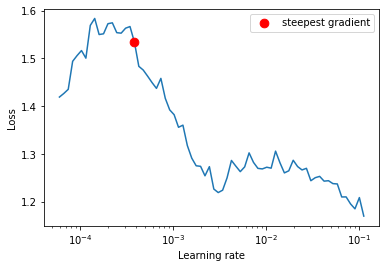

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.00038244348724062984)

In [18]:
CUDA_LAUNCH_BLOCKING=1
n_splits = 5
n_repeats = 1
group_count = 10

cv = regressor_stratified_cv(n_splits = n_splits, n_repeats = n_repeats,
                           group_count = group_count, random_state = 0, strategy = 'quantile')
i = 1
for train_idx, test_idx in cv.split(df["text"], df["target"].values):
    train_data = df.loc[train_idx]
    test_data = df.loc[test_idx]
    
train_set = TokenDataset(tokenizer,
                        text = train_data['text'].values,
                        target = train_data['target'].values
                        )

train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers=8)
    
custom_train_iter = CustomTrainIter(train_dataloader)
criterion = nn.MSELoss()
model = RobertaForSequenceRegression().to(device)
model_wrapper = ModelWrapper(model)
optimizer = SGD(model.parameters(), lr=2e-5, momentum=0.9)
lr_finder = LRFinder(model_wrapper, optimizer, criterion, device)
lr_finder.range_test(custom_train_iter, end_lr=1)
lr_finder.plot()

In [19]:
n_splits = 5
n_repeats = 1
group_count = 10

cv = regressor_stratified_cv(n_splits = n_splits, n_repeats = n_repeats,
                           group_count = group_count, random_state = 0, strategy = 'quantile')

df = df[['text', 'target']]

epochs = 30
n_epochs_stop = 10
epochs_no_improve = 0
training_stats = []
i = 1
eval_losses = []
for train_idx, test_idx in cv.split(df["text"], df["target"].values):
    print('======== Fold {:}  ========'.format(i))
    train_data = df.loc[train_idx]
    test_data = df.loc[test_idx]
    
    train_set = TokenDataset(tokenizer,
                            text = train_data['text'].values,
                            target = train_data['target'].values
                           )
    
    test_set = TokenDataset(tokenizer,
                           text = test_data['text'].values,
                           target = test_data['target'].values
                          )

    train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True, num_workers=8)

    test_dataloader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False, num_workers=8)
    
    model = RobertaForSequenceRegression().to(device)
#     optimizer = AdamW(model.parameters(),
#                       lr = 2e-5,
#                       weight_decay = 0.01
#                      )
    optimizer = SGD(model.parameters(), lr=3.82e-4, momentum=0.9)
#     total_steps = (len(train_dataloader) * epochs) 
#     scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = 10, T_mult = 1)
#     scheduler = OneCycleLR(optimizer, max_lr=2e-5, steps_per_epoch=len(train_dataloader), epochs=epochs)
    iters = len(train_dataloader)
#     scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = 0,
#                                             num_training_steps = total_steps)
#     scheduler = get_cosine_schedule_with_warmup(optimizer,
#                                                 num_warmup_steps=0, 
#                                                 num_training_steps= total_steps)
    iter_eval_loss = []
    min_eval_loss = np.Inf
    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        t0 = time.time()
        # training
        model.train()
        tr_loss = []
        for step, batch in enumerate(train_dataloader):
            ids = batch['ids'].to(device, dtype=torch.long)
            input_mask = batch['mask'].to(device, dtype=torch.long)
            target = batch['targets'].to(device, dtype=torch.float)
            optimizer.zero_grad()
            with autocast():
                output = model(ids, input_mask)
                loss = RMSELoss(output, target)
                tr_loss.append(loss.cpu().detach().numpy().tolist())

            loss.backward()
            optimizer.step()
#             scheduler.step(epoch_i + step/ iters)
        
        torch.cuda.empty_cache()
        train_losses = np.mean(tr_loss)  
        training_time = format_time(time.time() - t0)
        writer.add_scalar(f"Loss/train_fold_{i}", train_losses, epoch_i)
        print("Train loss: ", train_losses)
        print("Training epcoh took: {:}".format(training_time))
        
        # evaluation
        t0 = time.time()
        all_targets, all_preds = [], []
        model.eval()   
        eval_loss = []
        
        # disable gradients 
        with torch.no_grad(): 
            for batch in test_dataloader:
                ids = batch['ids'].to(device, dtype=torch.long)
                input_mask = batch['mask'].to(device, dtype=torch.long)
                target = batch['targets'].to(device, dtype=torch.float)
                output = model(ids, input_mask)
                loss = RMSELoss(output, target)
                eval_loss.append(loss.cpu().detach().numpy().tolist())
            
        epoch_eval_loss = np.mean(eval_loss)
        eval_time = format_time(time.time() - t0)
        writer.add_scalar(f"Loss/eval_fold_{i}", epoch_eval_loss, epoch_i)
        print("Eval loss: ", epoch_eval_loss)
        print("Evaluation took: {:}".format(eval_time))
        
        # recording all statistics from this epoch
        training_stats.append({
            'fold' : i,
            'epoch': epoch_i + 1,
            'Training Loss': train_losses,
            'Eval Loss': epoch_eval_loss,
            'Training Time': training_time,
            'Eval Time': eval_time
        })
        
        # early stopping and saving best model
        if epoch_eval_loss < min_eval_loss:
            epochs_no_improve = 0
            min_eval_loss = epoch_eval_loss
            best_model = copy.deepcopy(model)
            PATH = f'model_fold_{i}_epoch_{epoch_i+1}_loss_{round(epoch_eval_loss, 3)}.pt'
        else:
            epochs_no_improve += 1
#         if epochs_no_improve >= n_epochs_stop:
#             print('Early stopping! Epoch {:}'.format(epoch_i + 1) )
#             break
#         else:
#             continue
    
    torch.save(best_model.state_dict(), PATH)    
    i += 1    
    torch.cuda.empty_cache()
writer.flush()
writer.close()

======== Fold 1  ========

======== Epoch 1 / 30 ========
Train loss:  1.056304543370932
Training epcoh took: 0:01:20
Eval loss:  0.8699180798398124
Evaluation took: 0:00:07

======== Epoch 2 / 30 ========
Train loss:  0.7214763126742672
Training epcoh took: 0:01:20
Eval loss:  0.6790545160571734
Evaluation took: 0:00:07

======== Epoch 3 / 30 ========
Train loss:  0.6694185060094779
Training epcoh took: 0:01:20
Eval loss:  0.5779657289385796
Evaluation took: 0:00:07

======== Epoch 4 / 30 ========
Train loss:  0.6151235342865259
Training epcoh took: 0:01:20
Eval loss:  0.5816126192609469
Evaluation took: 0:00:07

======== Epoch 5 / 30 ========
Train loss:  0.5620421374767599
Training epcoh took: 0:01:20
Eval loss:  0.6769032817747858
Evaluation took: 0:00:07

======== Epoch 6 / 30 ========
Train loss:  0.5384575628059011
Training epcoh took: 0:01:20
Eval loss:  0.6744037634796567
Evaluation took: 0:00:07

======== Epoch 7 / 30 ========
Train loss:  0.5166100406310927
Training epcoh to

KeyboardInterrupt: 

In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'fold' as the row index.
# df_stats = df_stats.set_index('fold')
df_stats

In [ ]:
fig = plt.figure(figsize=(10, 15))
for fold in df_stats.fold.unique():
    ax = fig.add_subplot(5,1,fold)
    max_epoch = df_stats[df_stats['fold']==fold]['epoch'].max()
    x = np.arange(max_epoch)
    ax.plot(x,df_stats[df_stats['fold']==fold][['Training Loss']])
    ax.plot(x,df_stats[df_stats['fold']==fold][['Eval Loss']])
    plt.xticks(range(0, max_epoch, 5))

In [ ]:
# n_splits = 5
# n_repeats = 2
# group_count = 10
# cv = regressor_stratified_cv(n_splits = n_splits, n_repeats = n_repeats,
#                            group_count = group_count, random_state = 0, strategy = 'quantile')

# for train_index, test_index in cv.split(input_ids, targets):
#     train_inputs, test_inputs = input_ids[train_index], input_ids[test_index]
#     train_targets, test_targets = targets[train_index], targets[test_index]
#     train_masks, test_masks = attention_masks[train_index], attention_masks[test_index]
#     train_type_ids, test_type_ids = token_type_ids[train_index], token_type_ids[test_index]

In [ ]:
# train_inputs = torch.tensor(train_inputs, dtype=torch.long)
# test_inputs = torch.tensor(test_inputs, dtype=torch.long)
# train_targets = torch.tensor(train_targets, dtype=torch.float)
# test_targets = torch.tensor(test_targets, dtype=torch.float)
# train_masks = torch.tensor(train_masks, dtype=torch.long)
# test_masks = torch.tensor(test_masks, dtype=torch.long)
# train_type_ids = torch.tensor(train_type_ids, dtype=torch.long)
# test_type_ids = torch.tensor(test_type_ids, dtype=torch.long)

In [ ]:
# train_data = TensorDataset(train_inputs, train_masks, train_type_ids, train_targets)
# train_sampler = RandomSampler(train_data)
# train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)

# test_data = TensorDataset(test_inputs, test_masks, test_type_ids, test_targets)
# test_sampler = RandomSampler(test_data)
# test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = BATCH_SIZE)

In [ ]:
# set_trainable(model, True)
# set_trainable(model.bert.embeddings, True)    
# set_trainable(model.bert.encoder, True)

In [ ]:
# epochs = 5
# optimizer = AdamW(model.parameters(),
#                   lr = 5e-6,
#                   eps = 1e-6 
#                 )
# total_steps = len(train_dataloader) * epochs
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = 0,
#                                             num_training_steps = total_steps)
# eval_losses = []
# for epoch_i in range(0, epochs):
#     print("")
#     print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#     # training
#     model.train()
#     tr_loss = []
    
#     for step, batch in enumerate(train_dataloader):
#         batch = tuple(t.to(device) for t in batch)
#         ids, input_mask, type_ids, target = batch
#         output = model(ids, input_mask, type_ids, target)
#         loss = RMSELoss(output, target)
#         tr_loss.append(loss.cpu().detach().numpy().tolist())
#         loss.backward()  
#         optimizer.step()
#         optimizer.zero_grad()  
#         scheduler.step()
            
#     train_losses = np.mean(tr_loss)  
#     print("Train loss: ", train_losses)
#     all_targets, all_preds = [], []
#     model.eval()   
#     eval_loss = []
#     # evaluation
#     # disable gradients 
#     with torch.no_grad(): 
#         for batch in test_dataloader:
#             batch = tuple(t.to(device) for t in batch)
#             ids, input_mask, type_ids, target = batch
#             output = model(ids, input_mask, type_ids, target)
#             loss = RMSELoss(output, target)
#         eval_loss.append(loss.cpu().detach().numpy().tolist())
            
#     epoch_eval_loss = np.mean(eval_loss)
#     print("Eval loss: ", epoch_eval_loss)

#     eval_losses.append(epoch_eval_loss)   
# torch.cuda.empty_cache()
# mean_eval_loss = np.mean(eval_losses)
# print(mean_eval_loss)

In [ ]:
# test = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

In [ ]:
# test["text"] = test["excerpt"].apply(lambda x: text_preprocessing(x))

In [ ]:
# excerpts = test.text.values

In [ ]:
# # convert sentences into tokens
# input_ids = [tokenizer.encode(excerpt, add_special_tokens = True, max_length = MAX_LENGTH,
#                               padding='max_length') for excerpt in excerpts]

# input_ids = np.array(input_ids)
# attention_masks = []
# # create a mask of 1 for all input tokens and 0 for all padding tokens
# attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
# attention_masks = np.array(attention_masks)
# # create token type ids
# token_type_ids = [[0 for i in seq] for seq in input_ids]
# token_type_ids = np.array(token_type_ids)

In [ ]:
# input_ids = torch.tensor(input_ids, dtype=torch.long)
# attention_masks = torch.tensor(attention_masks, dtype=torch.long)
# token_type_ids = torch.tensor(token_type_ids, dtype=torch.long)

In [ ]:
# prediction_data = TensorDataset(input_ids, attention_masks, token_type_ids)
# prediction_sampler = SequentialSampler(prediction_data)
# prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

In [ ]:
# model.eval()   
# predictions , true_labels = [], []
# # evaluation
# for batch in prediction_dataloader:
#     # disable gradients 
#     batch = tuple(t.to(device) for t in batch)
#     ids, input_mask, type_ids = batch
#     with torch.no_grad():    
#         output = model(ids, input_mask, type_ids) 
#     output = output.cpu().detach().numpy().tolist()
#     predictions += output

In [ ]:
# submission = pd.DataFrame({'id':test['id'],'target':predictions})

In [ ]:
# submission.to_csv('submission.csv',index=False)

In [ ]:
# torch.cuda.empty_cache()